In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed
from dask.distributed import Client, progress
import dask.array as da
import dask.dataframe as dd
from dask_ml.preprocessing import DummyEncoder, StandardScaler
from dask_ml.model_selection import train_test_split
import joblib
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

import pandas as pd
import spacy

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(ddf):
    out = ddf.isnull().sum()*100/ddf.isnull().isnull().count()
    
    return print_full(out.compute())

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [4]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='3GB')
client

Client Scheduler: tcp://127.0.0.1:41175 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.00 GB


In [5]:
# read the first 10,000 rows in pandas to do understand the data structure
df = pd.read_csv(r'/home/owen/Jupyter/Capstone 4: Final Capstone/used_cars_data.csv', nrows=100000)

In [6]:
dtypes = {col : df[col].dtype for col in df.columns}

In [7]:
# These are retyped because they are being dropped
dtypes['sp_id'] = 'O'
dtypes['seller_rating'] = 'O'
dtypes['vehicle_damage_category'] = 'O'
dtypes['is_certified'] = 'O'
dtypes['combine_fuel_economy'] = 'O'
dtypes['listing_id'] = 'O'
dtypes['savings_amount'] = 'O'



# This contains problem values probably 4 digit codes
dtypes['dealer_zip'] = 'O'


In [8]:
# Load the data into Dask using the type map

df = dd.from_pandas(df, npartitions=5)

#df = dd.read_csv('/home/owen/Jupyter/Final/used_cars_data.csv', dtype=dtypes)

In [9]:
print_nulls(df)

vin                         0.000
back_legroom                4.954
bed                        99.393
bed_height                 91.877
bed_length                 91.877
body_type                   0.401
cabin                      98.333
city                        0.000
city_fuel_economy          16.016
combine_fuel_economy      100.000
daysonmarket                0.000
dealer_zip                  0.000
description                 2.543
engine_cylinders            2.998
engine_displacement         5.339
engine_type                 2.998
exterior_color              0.000
fleet                      43.075
frame_damaged              43.075
franchise_dealer            0.000
franchise_make             25.416
front_legroom               4.954
fuel_tank_volume            4.954
fuel_type                   2.459
has_accidents              43.075
height                      4.954
highway_fuel_economy       16.016
horsepower                  5.339
interior_color              0.000
isCab         

In [10]:
### Operations to clean the dataset
'''
Retain only some of the featuers.
Many contain redundant information or information that I am not using on this pass.
In particular I am not using location data on this pass. 
'''

df = df.dropna(subset=['fleet'
, 'frame_damaged'
, 'isCab'
, 'has_accidents'
, 'salvage'
, 'theft_title'])

#First Drop Duplicates
df = df.drop_duplicates(subset='vin')

# Limit the model to vehicles with NHTSA data available
df = df[df['year'] > 1984]




# Retain the columns first to reduce memory footprint
kept = ['vin' 
        , 'make_name' # Use make and body type instead of model
        #, 'model_name'
        , 'body_type'
        , 'year'
        , 'engine_type' # This contains the number of cylnders as well as their configureation.   
        , 'wheel_system'
        , 'transmission'
        #, 'trimId'
        #, 'trim_name'
        , 'horsepower'
        , 'maximum_seating'
        , 'mileage'
        
        
        # Target Variable
        , 'price'

        # Fuel Economy Variables
        , 'fuel_type'  
        , 'city_fuel_economy'
        , 'highway_fuel_economy'
        , 'combine_fuel_economy'

        , 'daysonmarket'
        , 'franchise_dealer'
        , 'is_cpo'
        
        # These Features would need NLP
        , 'description'
        , 'major_options'
        , 'exterior_color'
        , 'interior_color'

        # Have cleaning method but probably not necessary
        , 'front_legroom'
        , 'back_legroom'

        # Vehicle History Features
        , 'owner_count'
        , 'has_accidents'       
        , 'salvage'
        , 'theft_title'
        , 'fleet'
        , 'frame_damaged'
        , 'isCab' # Guessing this indicates that it was used for ridesharing?
       ]

df = df.loc[:, kept].copy()

# Use vin as index?
'''
May additionally need to add a vin checker here
'''
df = df.set_index('vin')


df.persist()

# Generate a make/model/yearname column?
    # Would be most helpful if/when I merge outside data.
    # Dictionary of these and each has its own model?
        # Is that just LIFT?
    
# Drop almost half the dataset because it is missing history?, Drop those features?
'''
In this pass I'm going to retain these columns and shrink the data. 
There is still more than enough and this way I may be able to create a classifier to
recommend if purchasing history will be worth it or not.


['fleet'
, 'frame_damaged'
, 'isCab'
, 'has_accidents'
, 'salvage'
, 'theft_title']

'''

# Color and Description both need to be parsed
'''
Just dropping them in this pass. Added to the drop below
'''    


# Define a function to retype columns with unit inches
def strip_inches(t):
    try:
        t = float(str(t).strip(' in'))
        return t
    except:
        return np.nan

cols = ['back_legroom', 'front_legroom']
    
for col in cols:
    df[col] = df[col].apply(strip_inches, meta=(col, 'int64'))
    

# Clean and retype seating capacity 
def fix_seating(r):
    try:
        r = int(str(r).strip(' seats'))
        return r
    except:
        return np.nan
    
df['maximum_seating'] = df['maximum_seating'].apply(fix_seating, meta=
                                                    ('maximum_seating', 'int64')).compute()


# Clean up boolean columns into numerical
df['is_cpo'] = df['is_cpo'].apply(lambda x: 1 if x == True else 0)

df['franchise_dealer'] = df['franchise_dealer'].apply(lambda x: 1 if x == True else 0)

df['fleet'] = df['fleet'].apply(lambda x: 1 if x == True else 0)

df['frame_damaged'] = df['frame_damaged'].apply(lambda x: 1 if x == True else 0)

df['isCab'] = df['isCab'].apply(lambda x: 1 if x == True else 0)

df['has_accidents'] = df['has_accidents'].apply(lambda x: 1 if x == True else 0)

df['salvage'] = df['salvage'].apply(lambda x: 1 if x == True else 0)

df['theft_title'] = df['theft_title'].apply(lambda x: 1 if x == True else 0)


# Decide what to do about fuel economy

    # EPA generates combined by weighting city 55% and highway 45%
df['combine_fuel_economy'] = df['city_fuel_economy']*0.55 + df['highway_fuel_economy']*0.45
    # Would be cool to see a model that encorporates a ratio as input?
    
    
    
# See if I can bin TrimID better
'''
Drop them in this pass
'''



# Drop some features
df = df.drop([ 'description'
              , 'major_options'
              , 'exterior_color'
              , 'interior_color'
             #, 'trimId'
             #, 'trim_name'
             ], axis=1).copy()


In [11]:
print_nulls(df)

make_name               0.000
body_type               0.069
year                    0.000
engine_type             1.836
wheel_system            2.709
transmission            0.841
horsepower              3.266
maximum_seating         3.329
mileage                 0.939
price                   0.000
fuel_type               1.551
city_fuel_economy      13.557
highway_fuel_economy   13.557
combine_fuel_economy   13.557
daysonmarket            0.000
franchise_dealer        0.000
is_cpo                  0.000
front_legroom           4.291
back_legroom            6.689
owner_count             4.553
has_accidents           0.000
salvage                 0.000
theft_title             0.000
fleet                   0.000
frame_damaged           0.000
isCab                   0.000
dtype: float64


In [12]:
df = df.dropna()

In [13]:
#plot_hist_boxplot(df.select_dtypes(include='number'))

In [14]:
# Apply a log transformation to price
df['price'] = np.log(df['price'])
df = df.categorize().compute()
de = DummyEncoder()
X = de.fit_transform(df)

In [15]:
scaler = StandardScaler()

In [16]:
#X = scaler.fit_transform(df.drop('price', axis=1))

In [17]:
y = X['price']
X = X.drop('price', axis=1)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)


In [19]:
lrm = LinearRegression()

with joblib.parallel_backend('dask'):
    scores = cross_validate(lrm, X_train, y_train, cv=4)
    
scores

{'fit_time': array([0.53974938, 0.5156827 , 0.94666719, 0.94220042]),
 'score_time': array([0.04242492, 0.02591538, 0.01424003, 0.01438403]),
 'test_score': array([0.91907079, 0.91876608, 0.91814035, 0.90511732])}

In [20]:
df

,make_name,body_type,year,engine_type,wheel_system,transmission,horsepower,maximum_seating,mileage,price,...,is_cpo,front_legroom,back_legroom,owner_count,has_accidents,salvage,theft_title,fleet,frame_damaged,isCab
vin,,,,,,,,,,,,,,,,,,,,,
19UDE2F30HA008509,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,47370.000,9.433,...,0,42.300,34.000,2.000,0,0,0,0,0,0
19UDE2F30KA001602,Acura,Sedan,2019,I4,FWD,A,201.000,5.000,30022.000,10.043,...,1,42.300,34.000,1.000,0,0,0,0,0,0
19UDE2F31HA005487,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,39195.000,9.540,...,0,42.300,34.000,2.000,1,0,0,0,0,0
19UDE2F31HA016411,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,6184.000,9.883,...,0,42.300,34.000,1.000,0,0,0,0,0,0
19UDE2F32HA002209,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,26184.000,9.868,...,0,42.300,34.000,1.000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFBCFYDB5HP537264,FIAT,SUV / Crossover,2017,I4,AWD,A,180.000,5.000,19348.000,9.740,...,0,41.400,34.800,1.000,0,0,0,0,0,0
ZFBCFYDT7GP511742,FIAT,SUV / Crossover,2016,I4,AWD,A,180.000,5.000,18497.000,9.729,...,0,41.400,34.800,1.000,0,0,0,0,0,0
ZFBCFYET3GP412978,FIAT,SUV / Crossover,2016,I4,AWD,A,180.000,5.000,34313.000,9.740,...,0,41.400,34.800,2.000,0,0,0,1,0,1


In [42]:
# create masks for the columns by type
conts = df.select_dtypes(include='number').columns
cats = df.select_dtypes(exclude='number').columns

<AxesSubplot:>

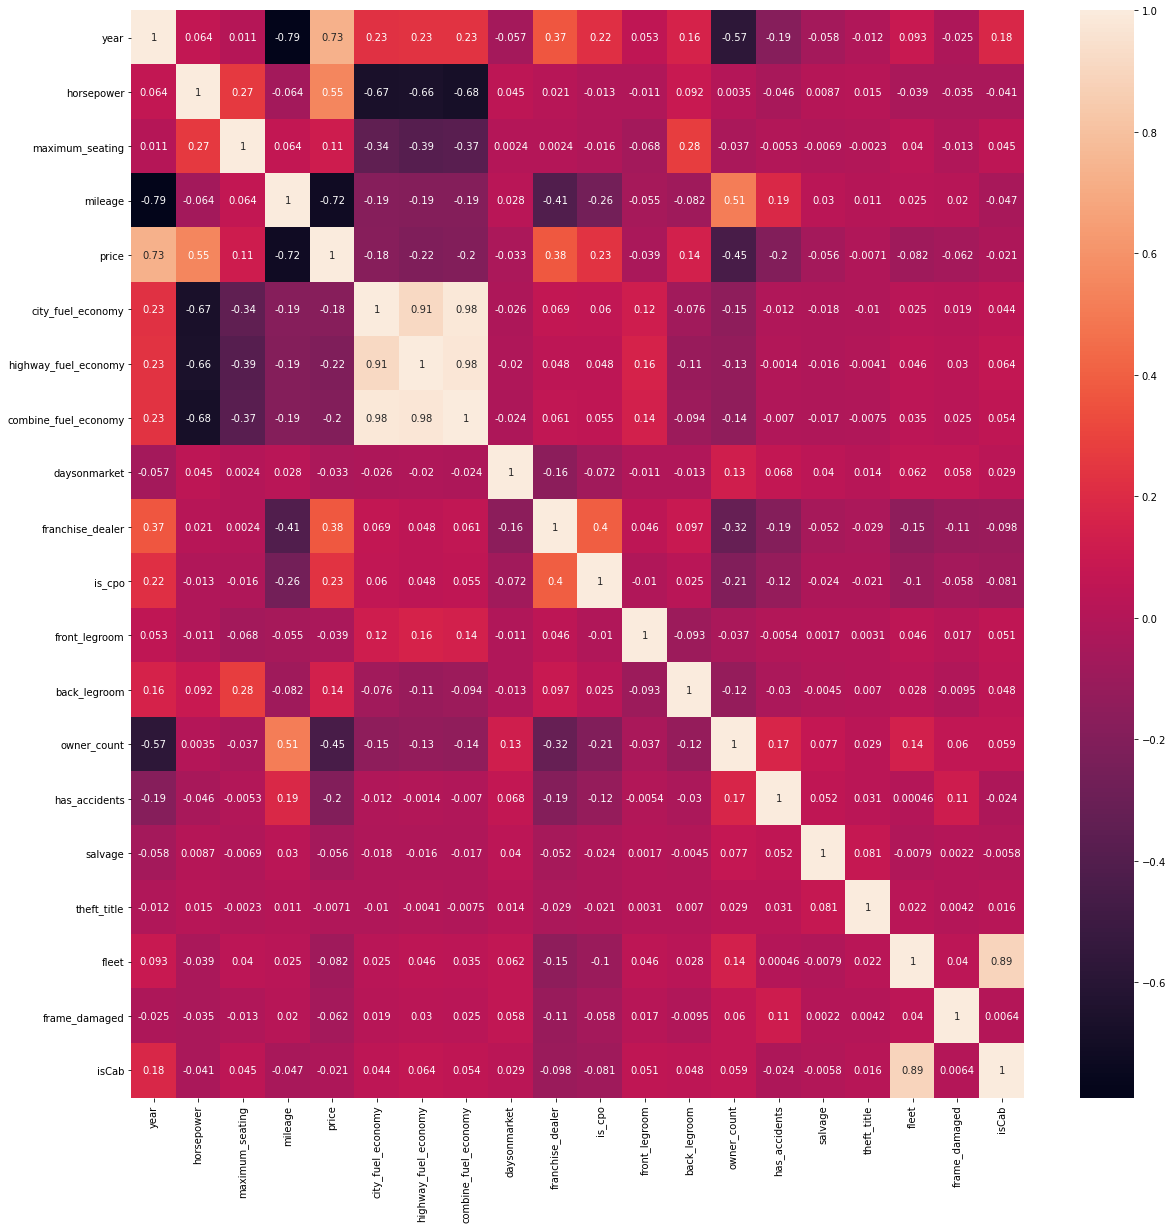

In [38]:
# Plot a heatmap of correlation
corr_map = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)

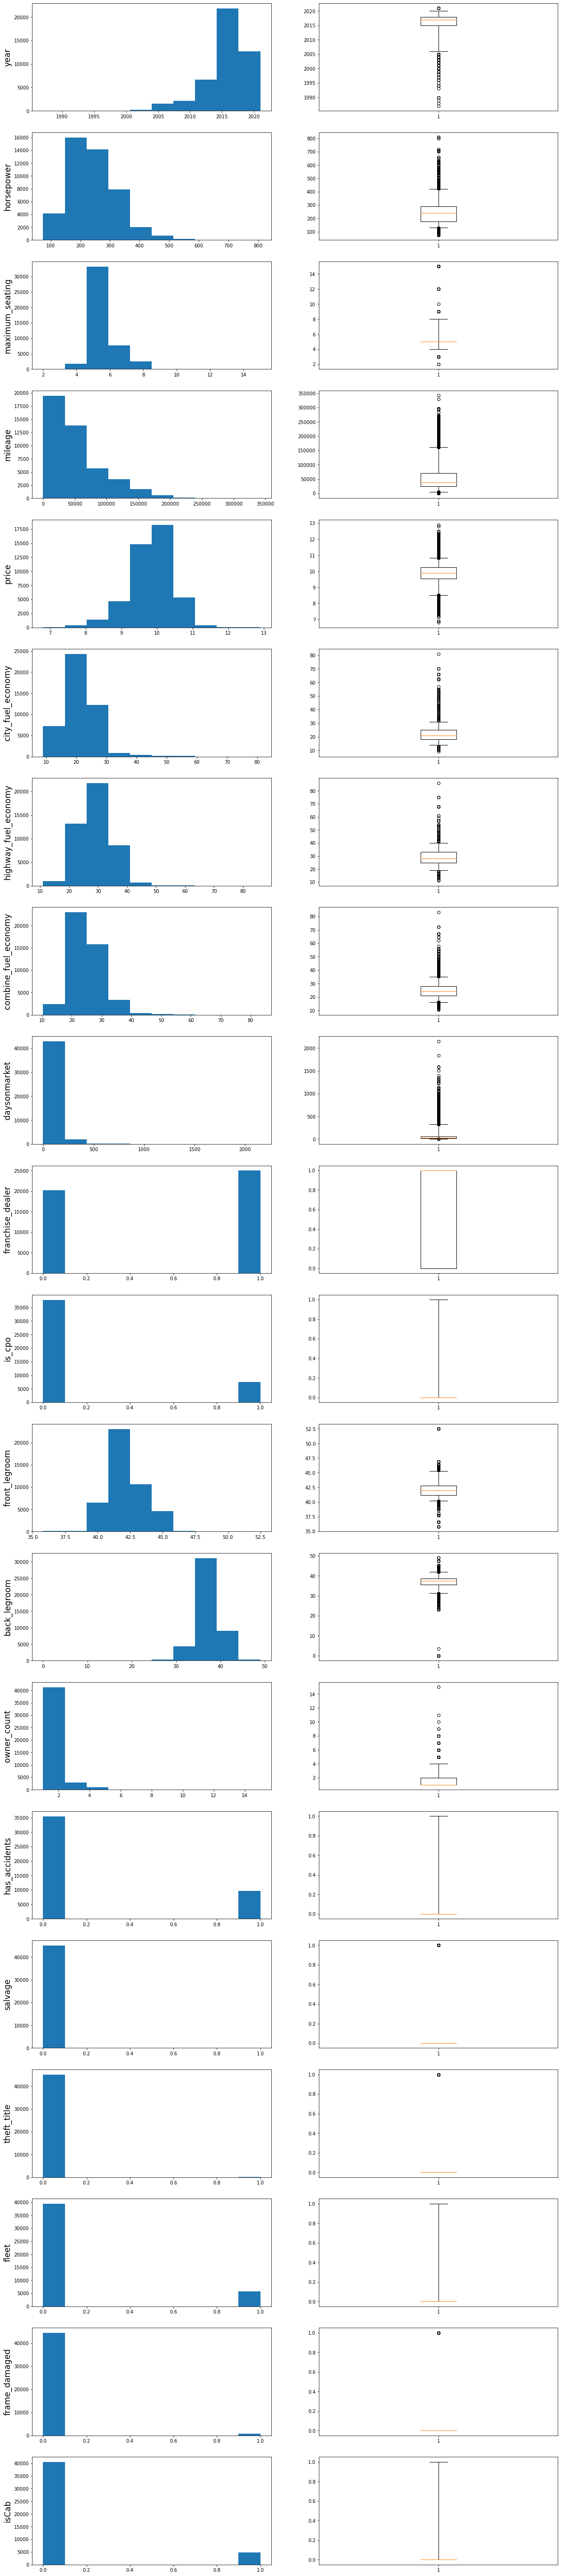

In [39]:
plot_hist_boxplot(df.select_dtypes(include='number'))

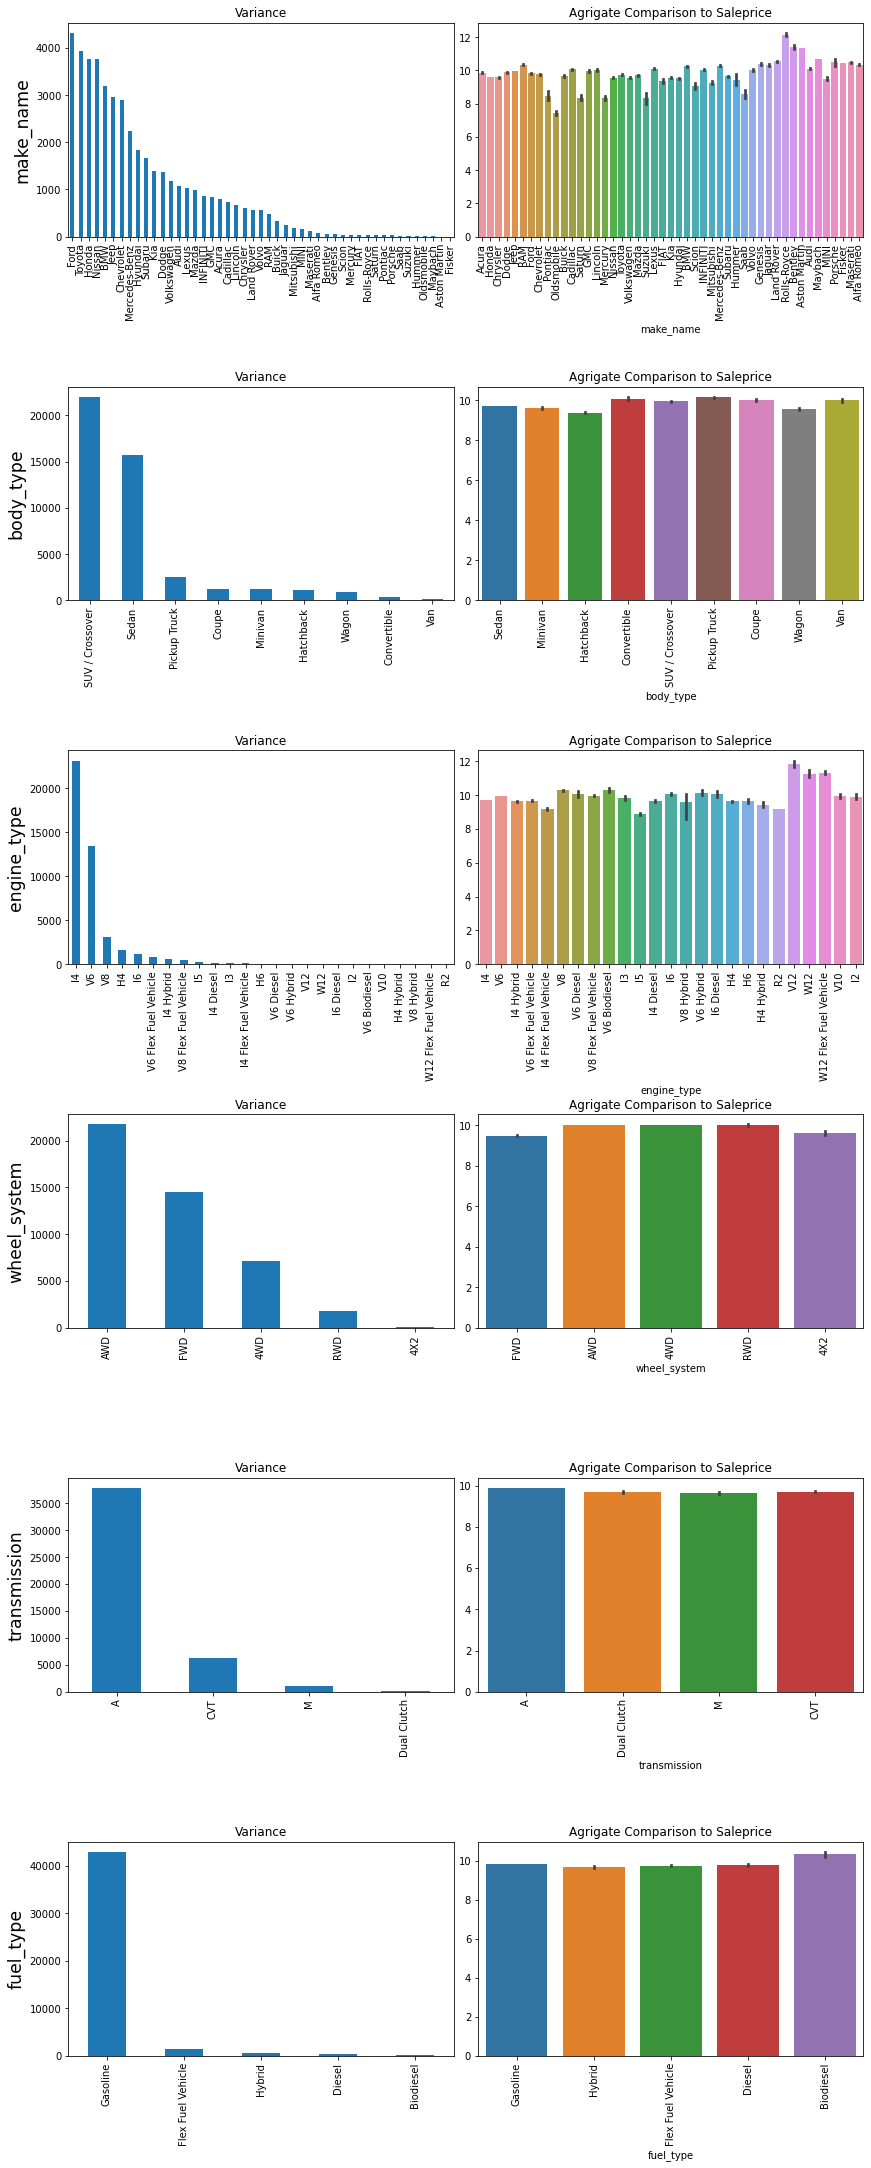

In [47]:
plt.figure(figsize=(12, len(cats)*5))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 2, (i+1)*2-1)
    df[feature].value_counts().plot(kind='bar')
    plt.ylabel(feature, size='xx-large')
    plt.title('Variance')
    plt.xlabel('')
    plt.xticks(rotation=90)
    
    
    plt.subplot(len(cats), 2, (i+1)*2)
    sns.barplot(x=df[feature], y=df['price'])
    plt.ylabel('')
    plt.title('Agrigate Comparison to Saleprice')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()

In [43]:
cats

Index(['make_name', 'body_type', 'engine_type', 'wheel_system', 'transmission',
       'fuel_type'],
      dtype='object')